In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import *
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
import nltk
import numpy as np

#### Download data from http://qwone.com/~jason/20Newsgroups/

In [2]:
# use four categories
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, categories=categories)

In [3]:
# dataset.data is a list of documents
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

3387 documents
4 categories


In [52]:
# examine the first document
dataset.data[0]

'From: healta@saturn.wwc.edu (Tammy R Healy)\nSubject: Re: who are we to judge, Bobby?\nLines: 38\nOrganization: Walla Walla College\nLines: 38\n\nIn article <1993Apr14.213356.22176@ultb.isc.rit.edu> snm6394@ultb.isc.rit.edu (S.N. Mozumder ) writes:\n>From: snm6394@ultb.isc.rit.edu (S.N. Mozumder )\n>Subject: Re: who are we to judge, Bobby?\n>Date: Wed, 14 Apr 1993 21:33:56 GMT\n>In article <healta.56.734556346@saturn.wwc.edu> healta@saturn.wwc.edu (TAMMY R HEALY) writes:\n>>Bobby,\n>>\n>>I would like to take the liberty to quote from a Christian writer named \n>>Ellen G. White.  I hope that what she said will help you to edit your \n>>remarks in this group in the future.\n>>\n>>"Do not set yourself as a standard.  Do not make your opinions, your views \n>>of duty, your interpretations of scripture, a criterion for others and in \n>>your heart condemn them if they do not come up to your ideal."\n>>                         Thoughts Fromthe Mount of Blessing p. 124\n>>\n>>I hope quoting 

### Preprocessing and calculate token frequency

In [53]:
# get a set of stopwords
stopwords = set(nltk.corpus.stopwords.words("english"))

import re
def before_token(documents):
    # conver words to lower case
    lower = map(str.lower, documents)
    # remove puntuations
    punctuationless = list(map(lambda x: " ".join(re.findall('\\b\\w\\w+\\b',x)), lower))
    # remove numbers
    return list(map(lambda x:re.sub('\\b[0-9]+\\b', '', x), punctuationless))

# initialize a stemmer
stemmer = nltk.stem.PorterStemmer()

# initialize a container of token frequencies
fdist = nltk.FreqDist()


# define a function that preprocess a single document and returns a list of tokens
def preprocess(doc):
    tokens = []
    for token in doc.split():
        if token not in stopwords:
            tokens.append(stemmer.stem(token))
    return tokens
            
# preprocess all documents
processed = list(map(preprocess, before_token(dataset.data)))
print(processed[0])

['healta', 'saturn', 'wwc', 'edu', 'tammi', 'heali', 'subject', 'judg', 'bobbi', 'line', 'organ', 'walla', 'walla', 'colleg', 'line', 'articl', '1993apr14', 'ultb', 'isc', 'rit', 'edu', 'snm6394', 'ultb', 'isc', 'rit', 'edu', 'mozumd', 'write', 'snm6394', 'ultb', 'isc', 'rit', 'edu', 'mozumd', 'subject', 'judg', 'bobbi', 'date', 'wed', 'apr', 'gmt', 'articl', 'healta', 'saturn', 'wwc', 'edu', 'healta', 'saturn', 'wwc', 'edu', 'tammi', 'heali', 'write', 'bobbi', 'would', 'like', 'take', 'liberti', 'quot', 'christian', 'writer', 'name', 'ellen', 'white', 'hope', 'said', 'help', 'edit', 'remark', 'group', 'futur', 'set', 'standard', 'make', 'opinion', 'view', 'duti', 'interpret', 'scriptur', 'criterion', 'other', 'heart', 'condemn', 'come', 'ideal', 'thought', 'fromth', 'mount', 'bless', 'hope', 'quot', 'make', 'atheist', 'gag', 'think', 'ellen', 'white', 'put', 'better', 'could', 'tammi', 'point', 'peac', 'bobbi', 'mozumd', 'point', 'set', 'view', 'way', 'believ', 'say', 'eveil', 'world'

In [54]:
# a single stemming example
stemmer.stem("running")

'run'

In [55]:
# calculate the token frequency
# the FreqDist function takes in a list of tokens and return a dict containg unique tokens and frequency
fdist = nltk.FreqDist([token for doc in processed for token in doc])

In [56]:
print("Unique tokens: %d" % fdist.B())
print("Total tokens: %d" % fdist.N())
print("Tokens occurred only once: %d" % len(fdist.hapaxes()))

Unique tokens: 29516
Total tokens: 616278
Tokens occurred only once: 10320


In [57]:
# check the token having the maximum frequency
fdist.max()

'edu'

In [58]:
# check the frequency of the above token
fdist[fdist.max()]

7061

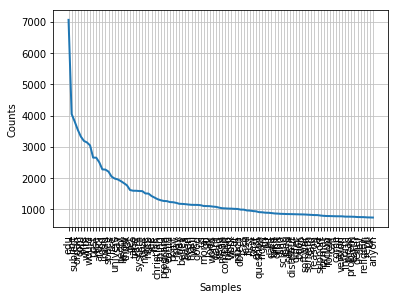

In [59]:
"%matplotlib inline"
fdist.plot(100)

In [60]:
fdist.tabulate(5)

    edu    line subject   organ     com 
   7061    4048    3807    3544    3326 


#### Vectorize the data

In [61]:
processed_doc = list(map(" ".join, processed))
# normalization is needed for clustering
vectorizer = TfidfVectorizer(max_df=0.8, stop_words='english')
X = vectorizer.fit_transform(processed_doc)

In [62]:
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 3387, n_features: 29357


In [63]:
km = KMeans(n_clusters=len(categories), max_iter=100, random_state=54321)
# km = KMeans(n_clusters=8, max_iter=100, random_state=54321)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=54321, tol=0.0001, verbose=0)

In [64]:
# examine each document's distance to each cluster
km.transform(X)

array([[0.99157666, 0.98074555, 1.08337499, 1.01058138],
       [0.99106105, 1.01222723, 1.09894713, 1.01574801],
       [0.99409988, 1.01635047, 1.10173921, 1.01455912],
       ...,
       [0.99109775, 1.00667103, 1.08946444, 0.9719261 ],
       [0.98969249, 1.01030374, 1.08824452, 1.01297934],
       [0.98307634, 1.01162261, 1.0987947 , 1.00612531]])

In [65]:
km.predict(X[0])

array([1])

In [66]:
dataset.target[0] # don't worry about this 

0

In [67]:
# examine the representative words for each cluster
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(len(categories)):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print

Cluster 0:
 edu
 com
 imag
 graphic
 univers
 post
 file
 use
 write
 comput
Cluster 1:
 god
 moral
 edu
 say
 christian
 peopl
 com
 keith
 write
 atheist
Cluster 2:
 sandvik
 kent
 appl
 newton
 com
 christian
 ksand
 alink
 cookamunga
 tourist
Cluster 3:
 space
 henri
 nasa
 access
 digex
 toronto
 edu
 orbit
 pat
 alaska


#### 10 fold cross validation using linear SVM

This implementation of SVM uses one-vs-one for multi-class classification

In [68]:
skf = model_selection.StratifiedKFold(n_splits=10)
fold = 0
for train_index, test_index in skf.split(np.array(processed_doc), dataset.target):
    fold += 1
    print("Fold %d" % fold)
    # partition
    train_x, test_x = np.array(processed_doc)[train_index], np.array(processed_doc)[test_index]
    train_y, test_y = dataset.target[train_index], dataset.target[test_index]
    # vectorize
    vectorizer = TfidfVectorizer(max_df=0.8, stop_words='english')
    X = vectorizer.fit_transform(train_x)
    print("Number of features: %d" % len(vectorizer.vocabulary_))
    X_test = vectorizer.transform(test_x)
    # train model
    clf = SVC(kernel="linear")
    clf.fit(X, train_y)
    # predict
    pred = clf.predict(X_test)
    # classification results
    for line in metrics.classification_report(test_y, pred).split("\n"):
        print(line)

Fold 1
Number of features: 27886
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        80
           1       0.96      0.98      0.97        98
           2       0.99      0.98      0.98        99
           3       0.97      0.90      0.93        63

   micro avg       0.96      0.96      0.96       340
   macro avg       0.96      0.96      0.96       340
weighted avg       0.97      0.96      0.96       340

Fold 2
Number of features: 27811
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        80
           1       0.98      1.00      0.99        98
           2       1.00      0.97      0.98        99
           3       0.95      0.89      0.92        63

   micro avg       0.96      0.96      0.96       340
   macro avg       0.96      0.96      0.96       340
weighted avg       0.97      0.96      0.96       340

Fold 3
Number of features: 27899
              precision    reca